In [1]:
import os
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from utils import *
from sklearn.metrics import mean_squared_error
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import shap

from model.StudentTest import StudentTest

/home/tatane/projets/ml_5DS/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


- [X] Charger les données
- [X] nettoyer les données
    - [X] Concaténer
    - [X] NaN
    - [X] duplication col / ligne
- [X] améliorer les données
    - [X] Ajouter variables
    - [X] retirer variables corrélées
    - [X] faire une séléction de variable à partir de la variance
    - [X] test student
    - [X] Normalize columns
- [X] Split train / test
- [X] tester de prédire la moyenne (indicateur)
- [X] entrainer des modèles (regression) sur le % d'infecté : (active + deaths + recovered) / population
    - [X] random forest
    - [ ] gradient boosting
    - [ ] SVR
    - [ ] regression pénalisée
    - [ ] Auto-ML
- [ ] Comparer les modèles
- [ ] Déterminer les variables ayant de l'impacte - Répondre à la problématique

Bonus: combler les nan avec la moyenne du groupe (clusterisation avec k-mean)


# Load Data

In [2]:
root_dir = "healthy_covid/"
repeated_col = ["Population", "Active", "Recovered", "Deaths", "Confirmed", "Undernourished", "Obesity"]
delete_col = ["Unit (all except Population)"] + repeated_col
delete_raw_df_col = ["active", "recovered", "deaths", "confirmed", "population"]

CONFIG = read_config_file("config.yml")

## Population info

In [3]:
df_fat_qqt = pd.read_csv(os.path.join(root_dir,"Fat_Supply_Quantity_Data.csv"))

# get global data
df_pop = df_fat_qqt.loc[:, repeated_col + ["Country"]]
df_pop.set_index("Country", inplace=True)
df_pop.rename(columns={old: camel_to_snake(old) for old in df_pop.columns},inplace=True)
df_pop.head()

,population,active,recovered,deaths,confirmed,undernourished,obesity
Country,,,,,,,
Afghanistan,38928000.00,0.02,0.09,0.00,0.11,29.8,4.50
Albania,2838000.00,0.53,0.50,0.02,1.05,6.2,22.30
Algeria,44357000.00,0.05,0.10,0.00,0.16,3.9,26.60
Angola,32522000.00,0.02,0.02,0.00,0.04,25,6.80
Antigua and Barbuda,98000.00,0.01,0.13,0.00,0.14,NaN,19.10


## Fat_Supply_Quantity_Data

In [4]:
df_fat_qqt.set_index("Country", inplace=True)
df_fat_qqt.drop(delete_col, axis="columns", inplace=True)
df_fat_qqt.rename(columns={old: camel_to_snake(old) for old in df_fat_qqt.columns},inplace=True)
df_fat_qqt = df_fat_qqt.add_prefix('fat_qqt_')
df_fat_qqt.head()


,fat_qqt_alcoholic_beverages,fat_qqt_animal_products,fat_qqt_animalfats,"fat_qqt_aquatic_products,_other",fat_qqt_cereals_excluding_beer,fat_qqt_eggs,"fat_qqt_fish,_seafood",fat_qqt_fruits_excluding_wine,fat_qqt_meat,fat_qqt_miscellaneous,...,fat_qqt_pulses,fat_qqt_spices,fat_qqt_starchy_roots,fat_qqt_stimulants,fat_qqt_sugar_crops,fat_qqt_sugar_&_sweeteners,fat_qqt_treenuts,fat_qqt_vegetal_products,fat_qqt_vegetable_oils,fat_qqt_vegetables
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,21.64,6.22,0.00,8.04,0.69,0.03,0.42,6.12,0.02,...,0.20,0.28,0.05,0.10,0.00,0.00,0.75,28.37,17.08,0.36
Albania,0.00,32.00,3.42,0.00,2.67,1.64,0.14,0.64,8.74,0.02,...,0.11,0.00,0.05,0.53,0.00,0.00,0.92,18.00,9.24,0.65
Algeria,0.00,14.42,0.90,0.00,4.20,1.22,0.20,0.58,3.90,0.04,...,0.27,0.16,0.11,0.29,0.00,0.00,0.86,35.59,27.36,0.51
Angola,0.00,15.30,1.31,0.00,6.55,0.15,1.42,0.35,11.03,0.03,...,0.33,0.01,0.71,0.11,0.00,0.00,0.03,34.70,22.46,0.12
Antigua and Barbuda,0.00,27.70,4.67,0.00,3.22,0.39,1.53,1.22,14.32,0.09,...,0.07,0.36,0.04,1.05,0.00,0.00,0.20,22.30,14.44,0.25


## Food_Supply_kcal_Data

In [5]:
df_kcal = pd.read_csv(os.path.join(root_dir,"Food_Supply_kcal_Data.csv"))
df_kcal.set_index("Country", inplace=True)
df_kcal.drop(delete_col, axis="columns", inplace=True)
df_kcal.rename(columns={old: camel_to_snake(old) for old in df_kcal.columns},inplace=True)
df_kcal = df_kcal.add_prefix('kcal_')
df_kcal.head()

,kcal_alcoholic_beverages,kcal_animal_products,kcal_animalfats,"kcal_aquatic_products,_other",kcal_cereals_excluding_beer,kcal_eggs,"kcal_fish,_seafood",kcal_fruits_excluding_wine,kcal_meat,kcal_milk_excluding_butter,...,kcal_pulses,kcal_spices,kcal_starchy_roots,kcal_stimulants,kcal_sugar_crops,kcal_sugar_&_sweeteners,kcal_treenuts,kcal_vegetal_products,kcal_vegetable_oils,kcal_vegetables
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,4.78,0.85,0.00,37.12,0.15,0.00,1.48,1.20,2.45,...,0.50,0.10,0.33,0.07,0.00,2.23,0.13,45.25,2.30,0.75
Albania,0.91,16.09,1.06,0.00,16.21,0.81,0.15,3.90,3.87,9.94,...,0.81,0.00,1.27,0.25,0.00,3.44,0.40,33.91,2.82,2.75
Algeria,0.09,6.03,0.19,0.00,25.01,0.42,0.12,3.18,1.25,3.99,...,1.09,0.12,1.93,0.15,0.00,3.99,0.22,43.97,5.76,2.05
Angola,1.94,4.69,0.26,0.00,18.35,0.04,0.84,2.31,2.93,0.51,...,1.50,0.00,12.62,0.04,0.00,2.75,0.00,45.32,4.27,0.35
Antigua and Barbuda,2.30,15.37,1.54,0.00,13.72,0.21,1.73,3.68,7.04,4.69,...,0.45,0.35,0.84,0.49,0.00,5.82,0.08,34.62,4.69,1.30


## Food_Supply_Quantity_kg_Data

In [6]:
df_kg = pd.read_csv(os.path.join(root_dir,"Food_Supply_Quantity_kg_Data.csv"))
df_kg.set_index("Country", inplace=True)
df_kg.drop(delete_col, axis="columns", inplace=True)
df_kg.rename(columns={old: camel_to_snake(old) for old in df_kg.columns},inplace=True)
df_kg = df_kg.add_prefix('kg_')
df_kg.head()

,kg_alcoholic_beverages,kg_animalfats,kg_animal_products,"kg_aquatic_products,_other",kg_cereals_excluding_beer,kg_eggs,"kg_fish,_seafood",kg_fruits_excluding_wine,kg_meat,kg_milk_excluding_butter,...,kg_pulses,kg_spices,kg_starchy_roots,kg_stimulants,kg_sugar_&_sweeteners,kg_sugar_crops,kg_treenuts,kg_vegetable_oils,kg_vegetables,kg_vegetal_products
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,0.20,9.43,0.00,24.81,0.21,0.04,5.35,1.20,7.58,...,0.30,0.06,0.88,0.31,1.35,0.00,0.08,0.53,6.76,40.56
Albania,1.67,0.14,18.77,0.00,5.78,0.58,0.21,6.79,1.88,15.72,...,0.24,0.00,1.81,0.11,1.54,0.00,0.15,0.33,11.78,31.23
Algeria,0.27,0.03,9.63,0.00,13.68,0.53,0.24,6.38,1.13,7.62,...,0.48,0.06,4.13,0.22,1.83,0.00,0.12,1.03,11.65,40.37
Angola,5.81,0.06,4.93,0.00,9.11,0.06,1.77,6.00,2.06,0.83,...,0.65,0.00,18.11,0.05,1.85,0.00,0.01,0.65,2.30,45.07
Antigua and Barbuda,3.58,0.01,16.66,0.00,6.00,0.23,4.15,10.75,5.69,6.37,...,0.18,0.15,1.45,0.16,3.87,0.00,0.03,0.81,5.45,33.32


##   Protein_Supply_Quantity_Data

In [7]:
df_protein_qqt = pd.read_csv(os.path.join(root_dir,"Protein_Supply_Quantity_Data.csv"))
df_protein_qqt.set_index("Country", inplace=True)
df_protein_qqt.drop(delete_col, axis="columns", inplace=True)
df_protein_qqt.rename(columns={old: camel_to_snake(old) for old in df_protein_qqt.columns},inplace=True)
df_protein_qqt = df_protein_qqt.add_prefix('protein_qqt_')
df_protein_qqt.head()

,protein_qqt_alcoholic_beverages,protein_qqt_animal_products,protein_qqt_animalfats,"protein_qqt_aquatic_products,_other",protein_qqt_cereals_excluding_beer,protein_qqt_eggs,"protein_qqt_fish,_seafood",protein_qqt_fruits_excluding_wine,protein_qqt_meat,protein_qqt_milk_excluding_butter,...,protein_qqt_spices,protein_qqt_starchy_roots,protein_qqt_stimulants,protein_qqt_sugar_crops,protein_qqt_sugar_&_sweeteners,protein_qqt_treenuts,protein_qqt_vegetal_products,protein_qqt_vegetable_oils,protein_qqt_vegetables,protein_qqt_miscellaneous
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,9.75,0.03,0.00,35.98,0.41,0.06,0.58,3.13,5.53,...,0.17,0.19,0.55,0.00,0.00,0.14,40.25,0.00,1.14,0.05
Albania,0.18,27.75,0.07,0.00,14.23,1.81,0.63,1.28,7.66,16.48,...,0.00,0.89,0.26,0.00,0.00,0.27,22.26,0.01,3.25,0.05
Algeria,0.03,13.84,0.01,0.00,26.56,1.29,0.64,1.16,3.51,8.06,...,0.18,1.46,0.46,0.00,0.00,0.27,36.17,0.03,3.13,0.14
Angola,0.63,15.23,0.03,0.00,20.39,0.18,5.44,1.28,7.62,1.15,...,0.00,5.19,0.10,0.00,0.01,0.01,34.78,0.01,0.81,0.09
Antigua and Barbuda,0.15,33.19,0.13,0.00,10.51,0.48,8.21,1.26,16.07,7.43,...,0.34,0.47,0.41,0.00,0.00,0.07,16.82,0.04,1.60,0.29


## Description categories

In [8]:
df_cat = pd.read_csv(os.path.join(root_dir,"Supply_Food_Data_Descriptions.csv"))
df_cat.head()

,Categories,Items
0,Alcoholic Beverages,"Alcohol, Non-Food; Beer; Beverages, Alcoholic;..."
1,Animal fats,"Butter, Ghee; Cream; Fats, Animals, Raw; Fish,..."
2,Animal Products,"Aquatic Animals, Others; Aquatic Plants; Bovin..."
3,"Aquatic Products, Other","Aquatic Animals, Others; Aquatic Plants; Meat,..."
4,Cereals - Excluding Beer,"Barley and products; Cereals, Other; Maize and..."


## check for each country if total sum equal 100%

In [9]:
for i_dict in [df_fat_qqt.sum(axis=1).to_dict(), df_kcal.sum(axis=1).to_dict(), df_protein_qqt.sum(axis=1).to_dict()]:
    for k, value in i_dict.items():
        if not 98 < value < 102:
            print(k)
else:
    print("All values == 100%")

All values == 100%


In [10]:
df_fat_qqt.sum(axis=1)

Country
Afghanistan                          100.00
Albania                              100.00
Algeria                              100.00
Angola                               100.00
Antigua and Barbuda                  100.00
                                      ...  
Venezuela (Bolivarian Republic of)   100.00
Vietnam                              100.00
Yemen                                100.00
Zambia                               100.00
Zimbabwe                             100.00
Length: 170, dtype: float64

## Concat

In [11]:
df_raw = pd.concat([df_fat_qqt, df_kcal, df_kg, df_protein_qqt, df_pop], axis="columns")
print("total shape :", df_raw.shape)
df_raw.head()


total shape : (170, 99)


,fat_qqt_alcoholic_beverages,fat_qqt_animal_products,fat_qqt_animalfats,"fat_qqt_aquatic_products,_other",fat_qqt_cereals_excluding_beer,fat_qqt_eggs,"fat_qqt_fish,_seafood",fat_qqt_fruits_excluding_wine,fat_qqt_meat,fat_qqt_miscellaneous,...,protein_qqt_vegetable_oils,protein_qqt_vegetables,protein_qqt_miscellaneous,population,active,recovered,deaths,confirmed,undernourished,obesity
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,21.64,6.22,0.00,8.04,0.69,0.03,0.42,6.12,0.02,...,0.00,1.14,0.05,38928000.00,0.02,0.09,0.00,0.11,29.8,4.50
Albania,0.00,32.00,3.42,0.00,2.67,1.64,0.14,0.64,8.74,0.02,...,0.01,3.25,0.05,2838000.00,0.53,0.50,0.02,1.05,6.2,22.30
Algeria,0.00,14.42,0.90,0.00,4.20,1.22,0.20,0.58,3.90,0.04,...,0.03,3.13,0.14,44357000.00,0.05,0.10,0.00,0.16,3.9,26.60
Angola,0.00,15.30,1.31,0.00,6.55,0.15,1.42,0.35,11.03,0.03,...,0.01,0.81,0.09,32522000.00,0.02,0.02,0.00,0.04,25,6.80
Antigua and Barbuda,0.00,27.70,4.67,0.00,3.22,0.39,1.53,1.22,14.32,0.09,...,0.04,1.60,0.29,98000.00,0.01,0.13,0.00,0.14,NaN,19.10


# Processing
## Nan description

In [12]:
print("Columns")
print({ k: v for k, v in df_raw.isnull().sum(axis=0).to_dict().items() if v != 0})
print("Rows")
print({ k: v for k, v in df_raw.isnull().sum(axis=1).to_dict().items() if v != 0})

df_raw.dropna(axis="index", inplace=True)
df = df_raw.copy()

Columns
{'active': 9, 'recovered': 7, 'deaths': 7, 'confirmed': 7, 'undernourished': 7, 'obesity': 3}
Rows
{'Antigua and Barbuda': 1, 'Bahamas': 1, 'Canada': 1, 'Chile': 1, 'French Polynesia': 5, 'Grenada': 1, 'Kiribati': 4, 'Korea, North': 4, 'Myanmar': 4, 'New Caledonia': 5, 'Republic of Moldova': 1, 'Saint Kitts and Nevis': 1, 'Saint Lucia': 1, 'Samoa': 4, 'Taiwan*': 1, 'Tajikistan': 1, 'Turkmenistan': 4}


## replace value

In [13]:
df.loc[df.undernourished=="<2.5", "undernourished"] = "2.5"
df["undernourished"] = df["undernourished"].astype("float")

## add new variables


In [14]:
df['ratio_total_infect'] = (df["active"] + df["deaths"] + df["recovered"])

df = df[[el for el in df.columns if el not in delete_raw_df_col]]

df.head()

,fat_qqt_alcoholic_beverages,fat_qqt_animal_products,fat_qqt_animalfats,"fat_qqt_aquatic_products,_other",fat_qqt_cereals_excluding_beer,fat_qqt_eggs,"fat_qqt_fish,_seafood",fat_qqt_fruits_excluding_wine,fat_qqt_meat,fat_qqt_miscellaneous,...,protein_qqt_sugar_crops,protein_qqt_sugar_&_sweeteners,protein_qqt_treenuts,protein_qqt_vegetal_products,protein_qqt_vegetable_oils,protein_qqt_vegetables,protein_qqt_miscellaneous,undernourished,obesity,ratio_total_infect
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,21.64,6.22,0.00,8.04,0.69,0.03,0.42,6.12,0.02,...,0.00,0.00,0.14,40.25,0.00,1.14,0.05,29.80,4.50,0.11
Albania,0.00,32.00,3.42,0.00,2.67,1.64,0.14,0.64,8.74,0.02,...,0.00,0.00,0.27,22.26,0.01,3.25,0.05,6.20,22.30,1.05
Algeria,0.00,14.42,0.90,0.00,4.20,1.22,0.20,0.58,3.90,0.04,...,0.00,0.00,0.27,36.17,0.03,3.13,0.14,3.90,26.60,0.16
Angola,0.00,15.30,1.31,0.00,6.55,0.15,1.42,0.35,11.03,0.03,...,0.00,0.01,0.01,34.78,0.01,0.81,0.09,25.00,6.80,0.04
Argentina,0.00,30.36,3.31,0.00,1.33,1.57,0.17,0.21,19.27,0.00,...,0.00,0.00,0.04,18.02,0.00,1.05,0.00,4.60,28.50,2.95


## Use student test to delete useless variable

In [15]:
col_number = df.shape[1]
student_t = StudentTest(df, 'ratio_total_infect')
col, df = student_t.fit()
print(f"number col delete {col_number - len(col)}")
df.head()

number col delete 8


,fat_qqt_alcoholic_beverages,fat_qqt_animal_products,fat_qqt_animalfats,"fat_qqt_aquatic_products,_other",fat_qqt_cereals_excluding_beer,fat_qqt_fruits_excluding_wine,fat_qqt_meat,fat_qqt_miscellaneous,fat_qqt_milk_excluding_butter,fat_qqt_offals,...,protein_qqt_sugar_crops,protein_qqt_sugar_&_sweeteners,protein_qqt_treenuts,protein_qqt_vegetal_products,protein_qqt_vegetable_oils,protein_qqt_vegetables,protein_qqt_miscellaneous,undernourished,obesity,ratio_total_infect
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,21.64,6.22,0.00,8.04,0.42,6.12,0.02,8.28,0.31,...,0.00,0.00,0.14,40.25,0.00,1.14,0.05,29.80,4.50,0.11
Albania,0.00,32.00,3.42,0.00,2.67,0.64,8.74,0.02,17.76,0.29,...,0.00,0.00,0.27,22.26,0.01,3.25,0.05,6.20,22.30,1.05
Algeria,0.00,14.42,0.90,0.00,4.20,0.58,3.90,0.04,8.09,0.11,...,0.00,0.00,0.27,36.17,0.03,3.13,0.14,3.90,26.60,0.16
Angola,0.00,15.30,1.31,0.00,6.55,0.35,11.03,0.03,1.23,0.15,...,0.00,0.01,0.01,34.78,0.01,0.81,0.09,25.00,6.80,0.04
Argentina,0.00,30.36,3.31,0.00,1.33,0.21,19.27,0.00,5.85,0.19,...,0.00,0.00,0.04,18.02,0.00,1.05,0.00,4.60,28.50,2.95


## Corrélation

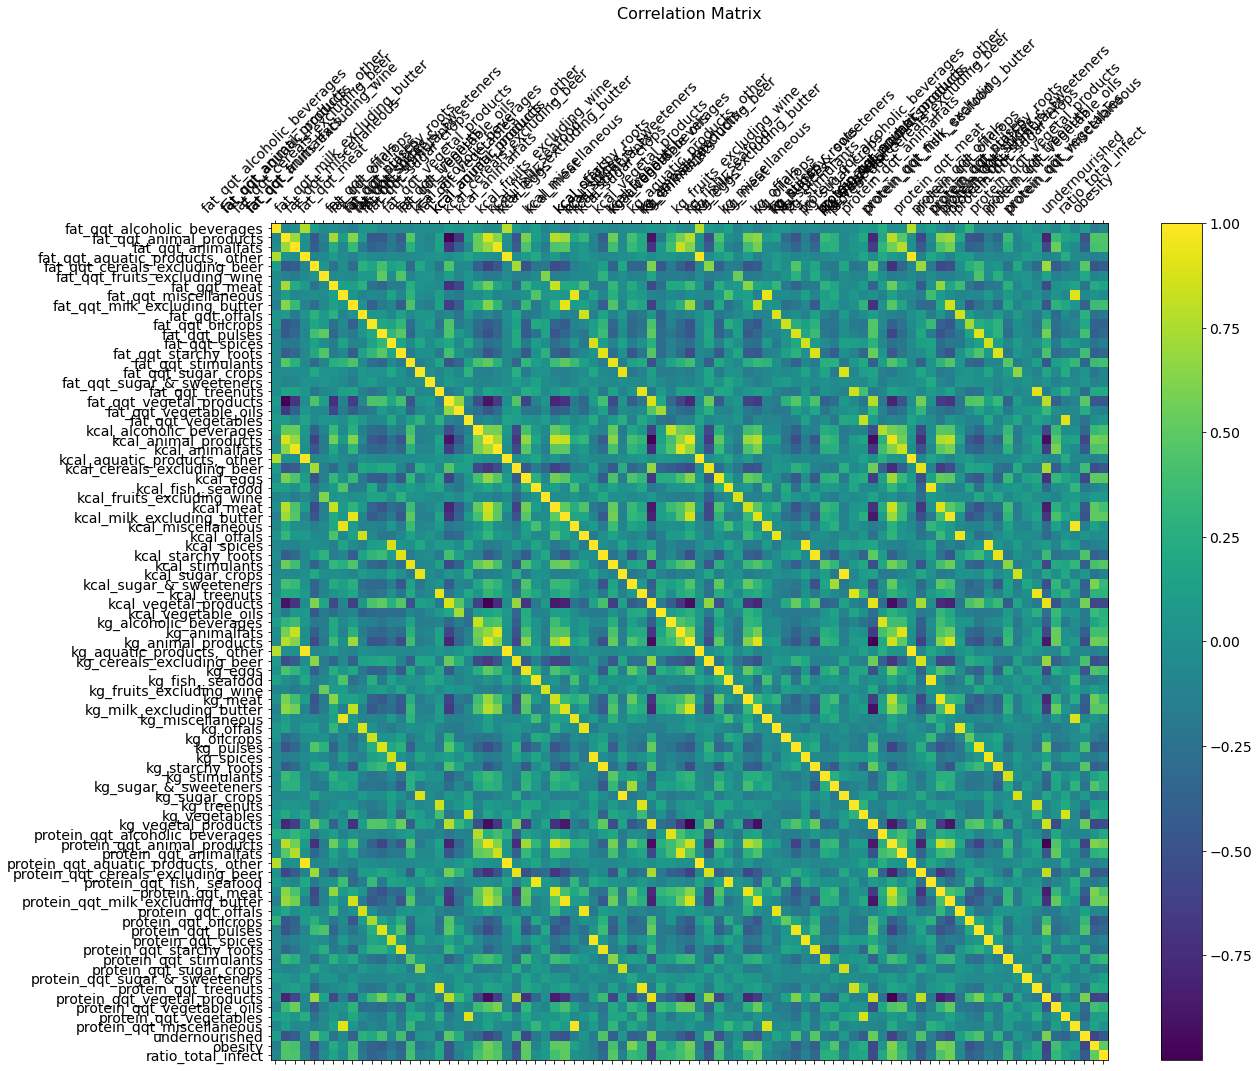

In [16]:
plot_correlation_matrix(df)

In [17]:
col_corr_list = get_correlated_columns(df, CONFIG["correlation_threshold"])
df = df[[el for el in df.columns if el not in col_corr_list or el == CONFIG["output_col"]]]
print(f"nombre de variables corrélés retirés: {len(col_corr_list)},  ratio: {int((len(col_corr_list) / df.shape[1]) * 100)} % ")
print(col_corr_list)
df.head()

nombre de variables corrélés retirés: 47,  ratio: 117 % 
{'kcal_animalfats', 'kg_milk_excluding_butter', 'kg_vegetal_products', 'kg_fruits_excluding_wine', 'kg_cereals_excluding_beer', 'kcal_offals', 'kcal_aquatic_products,_other', 'kcal_miscellaneous', 'protein_qqt_starchy_roots', 'kg_pulses', 'protein_qqt_vegetables', 'protein_qqt_miscellaneous', 'kcal_starchy_roots', 'protein_qqt_animal_products', 'kcal_vegetal_products', 'kg_aquatic_products,_other', 'protein_qqt_offals', 'kg_animalfats', 'fat_qqt_vegetal_products', 'kg_offals', 'protein_qqt_meat', 'protein_qqt_vegetal_products', 'kg_treenuts', 'kcal_sugar_crops', 'kg_alcoholic_beverages', 'protein_qqt_aquatic_products,_other', 'kg_fish,_seafood', 'kg_eggs', 'kcal_stimulants', 'kcal_spices', 'protein_qqt_spices', 'protein_qqt_pulses', 'kg_miscellaneous', 'kcal_milk_excluding_butter', 'kg_oilcrops', 'kg_starchy_roots', 'kg_sugar_crops', 'kcal_animal_products', 'protein_qqt_cereals_excluding_beer', 'protein_qqt_treenuts', 'kcal_treen

,fat_qqt_alcoholic_beverages,fat_qqt_animal_products,fat_qqt_animalfats,"fat_qqt_aquatic_products,_other",fat_qqt_cereals_excluding_beer,fat_qqt_fruits_excluding_wine,fat_qqt_meat,fat_qqt_miscellaneous,fat_qqt_milk_excluding_butter,fat_qqt_offals,...,kg_sugar_&_sweeteners,protein_qqt_alcoholic_beverages,protein_qqt_animalfats,protein_qqt_oilcrops,protein_qqt_sugar_crops,protein_qqt_sugar_&_sweeteners,protein_qqt_vegetable_oils,undernourished,obesity,ratio_total_infect
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,21.64,6.22,0.00,8.04,0.42,6.12,0.02,8.28,0.31,...,1.35,0.00,0.03,0.20,0.00,0.00,0.00,29.80,4.50,0.11
Albania,0.00,32.00,3.42,0.00,2.67,0.64,8.74,0.02,17.76,0.29,...,1.54,0.18,0.07,0.37,0.00,0.00,0.01,6.20,22.30,1.05
Algeria,0.00,14.42,0.90,0.00,4.20,0.58,3.90,0.04,8.09,0.11,...,1.83,0.03,0.01,0.18,0.00,0.00,0.03,3.90,26.60,0.16
Angola,0.00,15.30,1.31,0.00,6.55,0.35,11.03,0.03,1.23,0.15,...,1.85,0.63,0.03,2.15,0.00,0.01,0.01,25.00,6.80,0.04
Argentina,0.00,30.36,3.31,0.00,1.33,0.21,19.27,0.00,5.85,0.19,...,3.05,0.17,0.01,0.01,0.00,0.00,0.00,4.60,28.50,2.95


In [18]:
len(get_correlated_columns(df, CONFIG["correlation_threshold"]))

0

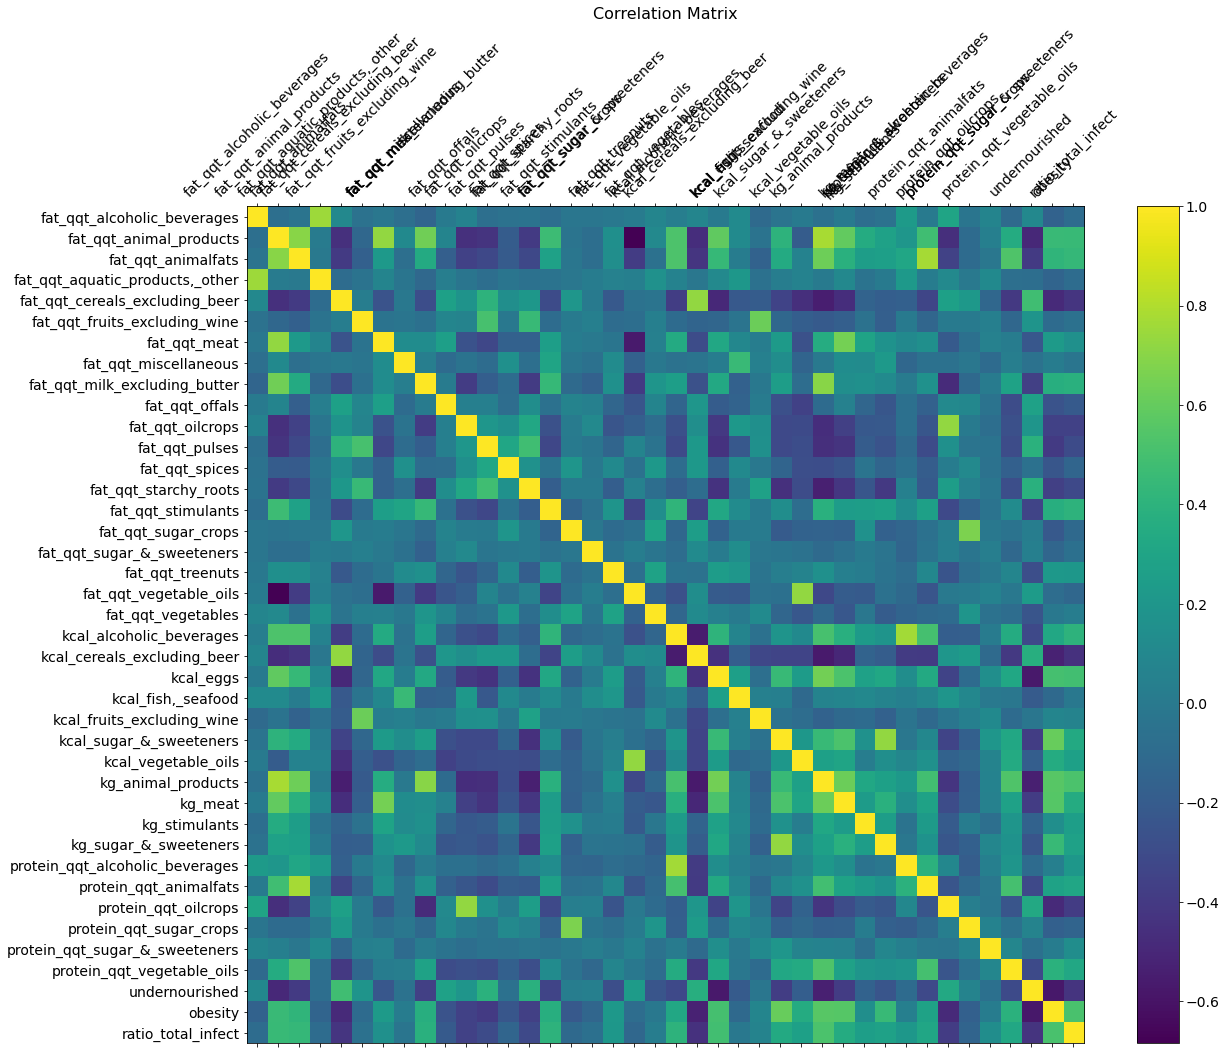

In [19]:
plot_correlation_matrix(df)

## Delete variable with not enough variance

In [20]:
var_series = df.var()
delete_col_list = [col for col in df.columns if not var_series[col] > CONFIG["variance_threshold"] ]
df = df[[el for el in df.columns if el not in delete_col_list or el == CONFIG["output_col"]]]
print(f"Number column delete {len(delete_col_list)}")
print(delete_col_list)
print(f"shape : {df.shape}, ratio: {int((1 - df.shape[1] / len(var_series)) * 100)} % ")
df.head()

Number column delete 14
['fat_qqt_alcoholic_beverages', 'fat_qqt_aquatic_products,_other', 'fat_qqt_miscellaneous', 'fat_qqt_offals', 'fat_qqt_sugar_crops', 'fat_qqt_sugar_&_sweeteners', 'fat_qqt_vegetables', 'kcal_eggs', 'kg_stimulants', 'protein_qqt_alcoholic_beverages', 'protein_qqt_animalfats', 'protein_qqt_sugar_crops', 'protein_qqt_sugar_&_sweeteners', 'protein_qqt_vegetable_oils']
shape : (153, 26), ratio: 35 % 


,fat_qqt_animal_products,fat_qqt_animalfats,fat_qqt_cereals_excluding_beer,fat_qqt_fruits_excluding_wine,fat_qqt_meat,fat_qqt_milk_excluding_butter,fat_qqt_oilcrops,fat_qqt_pulses,fat_qqt_spices,fat_qqt_starchy_roots,...,kcal_fruits_excluding_wine,kcal_sugar_&_sweeteners,kcal_vegetable_oils,kg_animal_products,kg_meat,kg_sugar_&_sweeteners,protein_qqt_oilcrops,undernourished,obesity,ratio_total_infect
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,21.64,6.22,8.04,0.42,6.12,8.28,1.05,0.20,0.28,0.05,...,1.48,2.23,2.30,9.43,1.20,1.35,0.20,29.80,4.50,0.11
Albania,32.00,3.42,2.67,0.64,8.74,17.76,3.16,0.11,0.00,0.05,...,3.90,3.44,2.82,18.77,1.88,1.54,0.37,6.20,22.30,1.05
Algeria,14.42,0.90,4.20,0.58,3.90,8.09,1.20,0.27,0.16,0.11,...,3.18,3.99,5.76,9.63,1.13,1.83,0.18,3.90,26.60,0.16
Angola,15.30,1.31,6.55,0.35,11.03,1.23,3.99,0.33,0.01,0.71,...,2.31,2.75,4.27,4.93,2.06,1.85,2.15,25.00,6.80,0.04
Argentina,30.36,3.31,1.33,0.21,19.27,5.85,0.06,0.02,0.02,0.11,...,1.47,7.05,5.54,19.35,7.04,3.05,0.01,4.60,28.50,2.95


4.739791576204953


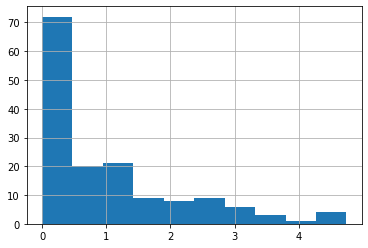

In [21]:
df["ratio_total_infect"].hist()
print(df["ratio_total_infect"].max())

## Normalize y

In [22]:
# x = df.values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df_norm = pd.DataFrame(x_scaled, columns=df.columns)
# df_norm["ratio_total_infect"] = df["ratio_total_infect"]
#
# df_norm.head()

df_norm = df.copy()

# Train model

In [23]:
X = df_norm[[col for col in df.columns if col != "ratio_total_infect"]]
y = df_norm[["ratio_total_infect"]]

## Naive model (predict mean)

In [24]:
from model.NaiveModel import NaiveModel

naive_model = NaiveModel()
score = naive_model.fit(X, y)
score.get_score_df()

,mse,r_square,mae
train,1.24,0.00,0.90
test,2.22,-0.05,1.09


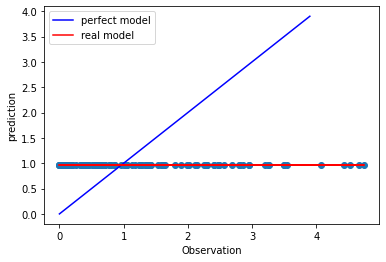

In [25]:
_ = score.get_plot()

## Random forest (hyper optimize)

In [26]:
from model.HyperOptimizedRandomForest import HyperOptimizedRandomForest


h_rf = HyperOptimizedRandomForest()
h_rf.fit(X, y)
score = h_rf.fit_best_rf(X, y)
display(score.get_score_df())

,mse,r_square,mae
train,0.45,0.67,0.48
test,0.93,0.28,0.69


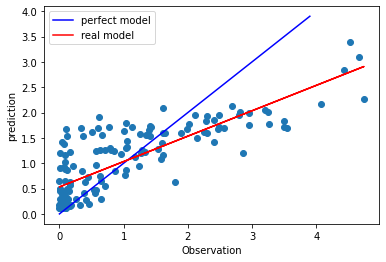

In [27]:
_ = score.get_plot()

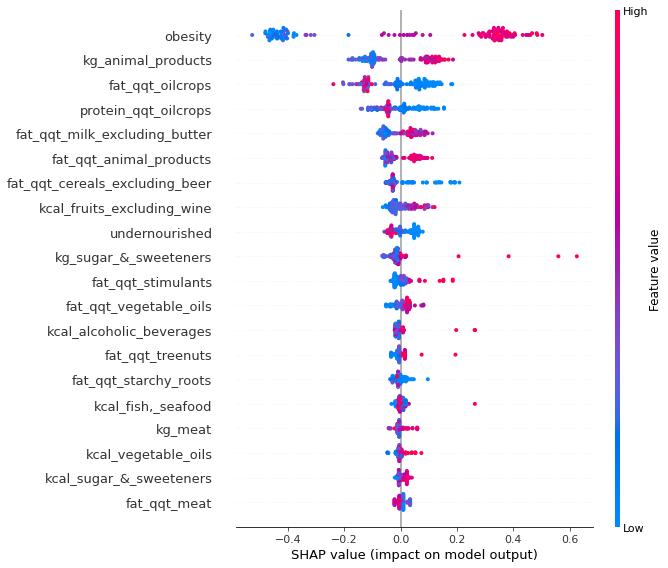

In [28]:
shap_values = shap.TreeExplainer(h_rf.model).shap_values(h_rf.X_train)
shap.summary_plot(shap_values, h_rf.X_train, feature_names=df.columns)

## Elastic Net (hyper optimize)

In [29]:
from model.HyperOptimizedElasticNet import HyperOptimizedElasticNet


h_elastic = HyperOptimizedElasticNet()
h_elastic.fit(X, y)
score = h_elastic.fit_best_elastic(X, y)
display(score.get_score_df())

,mse,r_square,mae
train,0.81,0.39,0.64
test,0.89,0.34,0.67


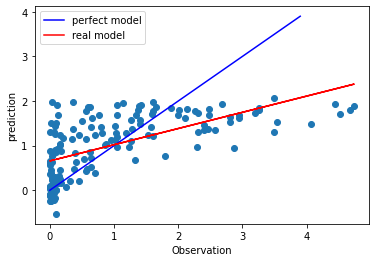

In [30]:
_ = score.get_plot()

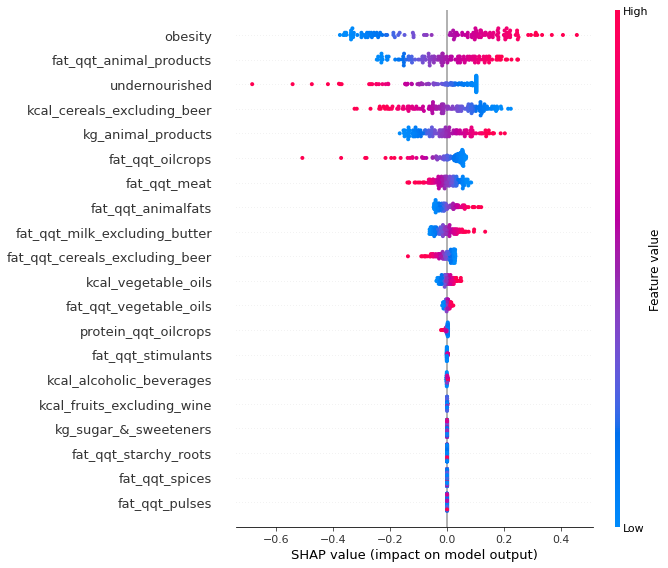

In [31]:
shap_values = shap.LinearExplainer(h_elastic.model, h_elastic.X_train).shap_values(h_elastic.X_train)
shap.summary_plot(shap_values, h_elastic.X_train, feature_names=df.columns)

## SVM regression

In [32]:
from model.SVM import SVM


svm = SVM()
score = svm.fit(X, y)
display(score.get_score_df())

,mse,r_square,mae
train,0.78,0.42,0.56
test,0.91,0.32,0.64


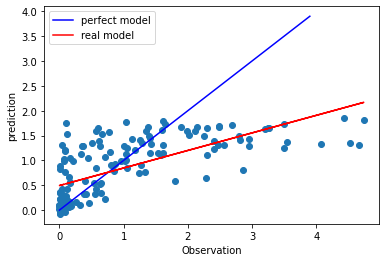

In [33]:
_ = score.get_plot()

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


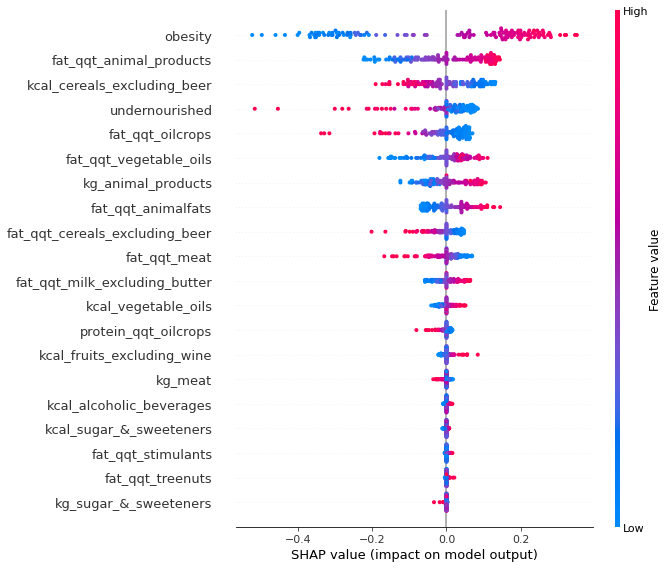

In [34]:
shap_values = shap.KernelExplainer(svm.model.predict, svm.X_train).shap_values(svm.X_train)
shap.summary_plot(shap_values, svm.X_train, feature_names=df.columns)

## KNN regression

In [35]:
from model.KNN import KNN


knn = KNN()
score_dict = knn.fit(X, y, 11, 11)
for k, v in score_dict.items():
    display(k)
    display(v.get_score_df())

11

,mse,r_square,mae
train,0.71,0.47,0.61
test,0.84,0.35,0.68


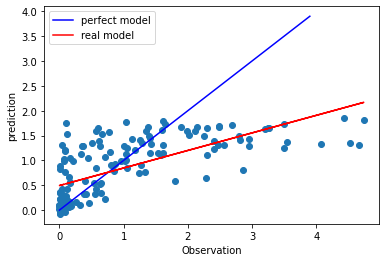

In [36]:
_ = score.get_plot()

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


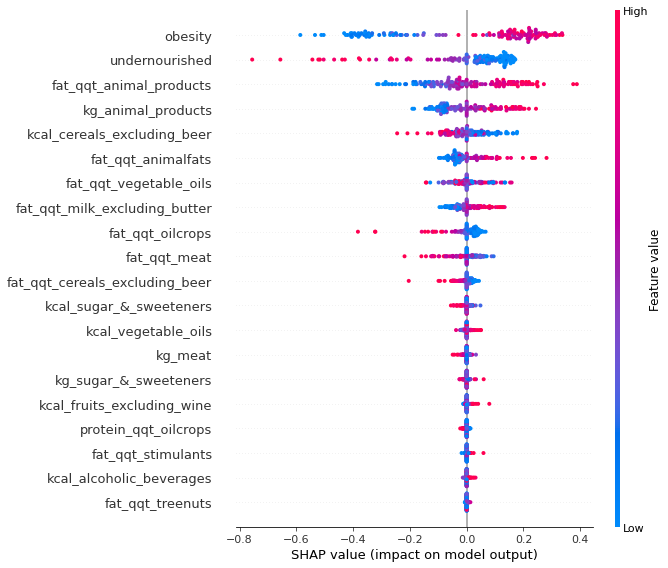

In [37]:
shap_values = shap.KernelExplainer(knn.model.predict, knn.X_train).shap_values(knn.X_train)
shap.summary_plot(shap_values, knn.X_train, feature_names=df.columns)



